In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input, Concatenate, BatchNormalization
from tqdm import tqdm

### Multi-Task Learning

Multi-Task Learning is a type of learning where the model learns two tasks with same set or multiple sets of data. With the intention of learning two patterns (for example - regression and classification), instead of making two models, we can try building a single model with multiple heads at the end such that both these tasks augment/complement each other, thereby improving learning beyond what can be achieved by single task network.

Multi-Task Learning is different from multi-output training as the former is a broader class where different sets of data can be used together to model a single network while the latter typically uses a single source of data to learn multiple outputs.

### Problem Formulation

In this notebook, we will use the MNIST dataset to build a multi-task framework. We will stitch digit images together such that the model predict digits individually and sum of digits together. So there are two heads - classification and regression heads. Accordingly, there are two loss functions: 
1. Binary Cross Entropy for Multi-Label Classification, Activation at output - Sigmoid
2. Mean Squared Error for Regression, Activation at output - ReLU

In [2]:
img_size = 56
num_classes = 10

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
train_idxs = np.arange(X_train.shape[0])
np.random.shuffle(train_idxs)
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

In [5]:
def make_example(X_train, y_train, batch):
    idx1, idx2, idx3, idx4 = 4 * batch, 4 * batch + 1, 4 * batch + 2, 4 * batch + 3
    r1 = np.hstack((X_train[idx1], X_train[idx2]))
    r2 = np.hstack((X_train[idx3], X_train[idx4]))
    img = np.vstack((r1, r2))
    digits = keras.utils.to_categorical(y_train[[idx1, idx2, idx3, idx4]], num_classes = num_classes)
    digits = np.sum(digits, axis=0)
    digits_sum = np.sum(y_train[[idx1, idx2, idx3, idx4]])
    return img, digits, digits_sum

In [6]:
num_images = 60000
digits_per_image = 4
imgs = []
label1 = []
label2 = []

for batch in tqdm(range(num_images // digits_per_image)):
    img, digits, digits_sum = make_example(X_train, y_train, batch)
    imgs.append(img)
    label1.append(digits)
    label2.append(digits_sum)

imgs = np.array(imgs)
label1 = np.array(label1)
label2 = np.array(label2)

imgs.shape, label1.shape, label2.shape

100%|██████████| 15000/15000 [00:00<00:00, 21175.79it/s]


((15000, 56, 56), (15000, 10), (15000,))

Digits: [1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
Digit Sum: 24


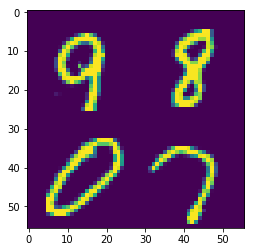

In [7]:
idx = 0
print('Digits:', label1[idx])
print('Digit Sum:', label2[idx])
plt.imshow(imgs[idx])
plt.show()

In [8]:
inp = Input(shape=(img_size, img_size, 1))
x = Conv2D(64, kernel_size=(3,3), activation='relu')(inp)
x = MaxPool2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out1 = Dense(num_classes, activation='sigmoid', name='classification')(x)
out2 = Dense(1, activation='relu', name='regression')(x)

model = Model(inputs = inp, outputs = [out1, out2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 54, 54, 64)   640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 27, 27, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

2022-03-27 14:44:29.161051: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
loss_fn = {'classification':'binary_crossentropy', 'regression':'mean_squared_error'} 
model.compile(loss=loss_fn, optimizer=keras.optimizers.Adam())

history = model.fit(imgs, [label1, label2], epochs = 5, shuffle = True, 
                    batch_size = 1024, validation_split = 0.2, verbose=1)

Epoch 1/5
12/12 [==============================] - 20s 2s/step - loss: 242.4154 - classification_loss: 0.9338 - regression_loss: 241.4816 - val_loss: 11109.4492 - val_classification_loss: 5.8328 - val_regression_loss: 11103.6162
Epoch 2/5
12/12 [==============================] - 19s 2s/step - loss: 198.3049 - classification_loss: 0.8302 - regression_loss: 197.4747 - val_loss: 2132.4333 - val_classification_loss: 2.1276 - val_regression_loss: 2130.3057
Epoch 3/5
12/12 [==============================] - 19s 2s/step - loss: 178.4510 - classification_loss: 0.7778 - regression_loss: 177.6731 - val_loss: 669.4128 - val_classification_loss: 1.2924 - val_regression_loss: 668.1204
Epoch 4/5
12/12 [==============================] - 18s 2s/step - loss: 161.4539 - classification_loss: 0.7474 - regression_loss: 160.7065 - val_loss: 316.8817 - val_classification_loss: 1.0965 - val_regression_loss: 315.7852
Epoch 5/5
12/12 [==============================] - 17s 1s/step - loss: 147.0352 - classificati

In [10]:
def plotting(train_loss1, train_loss2, train_loss3, val_loss1, val_loss2, val_loss3):
    plt.figure(figsize=(20,5))

    plt.subplot(131)
    plt.plot(train_loss1, label='Training')
    plt.plot(val_loss1, label='Validation')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(132)
    plt.plot(train_loss2, label='Training')
    plt.plot(val_loss2, label='Validation')
    plt.title('Classification Loss')
    plt.legend()

    plt.subplot(133)
    plt.plot(train_loss3, label='Training')
    plt.plot(val_loss3, label='Validation')
    plt.title('Regression Loss')
    plt.legend()
    plt.show()

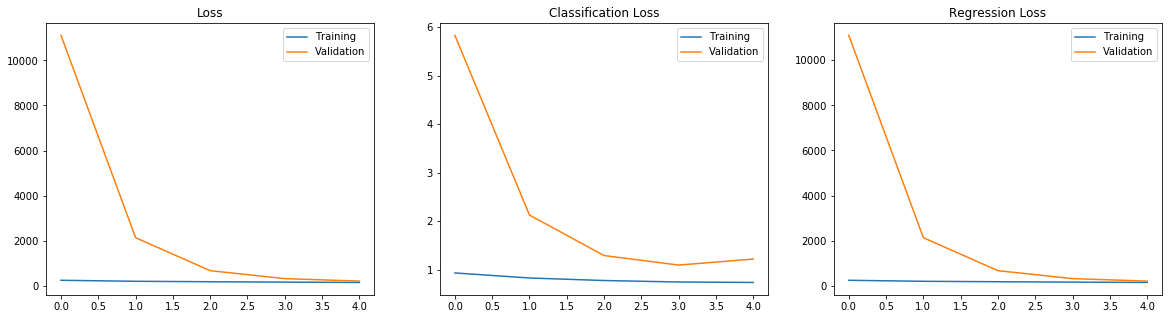

In [11]:
train_loss1 = history.history['loss']
train_loss2 = history.history['classification_loss']
train_loss3 = history.history['regression_loss']
val_loss1 = history.history['val_loss']
val_loss2 = history.history['val_classification_loss']
val_loss3 = history.history['val_regression_loss']

plotting(train_loss1, train_loss2, train_loss3, val_loss1, val_loss2, val_loss3)

### Inference

In [12]:
num_images = 10000
digits_per_image = 4
test_imgs = []
test_label1 = []
test_label2 = []

for batch in tqdm(range(num_images // digits_per_image)):
    img, digits, digits_sum = make_example(X_test, y_test, batch)
    test_imgs.append(img)
    test_label1.append(digits)
    test_label2.append(digits_sum)

test_imgs = np.array(test_imgs)
test_label1 = np.array(test_label1)
test_label2 = np.array(test_label2)

test_imgs.shape, test_label1.shape, test_label2.shape

100%|██████████| 2500/2500 [00:00<00:00, 16765.47it/s]


((2500, 56, 56), (2500, 10), (2500,))

Digits: [8 1 2 7]
Digit Sum: 4.446935653686523


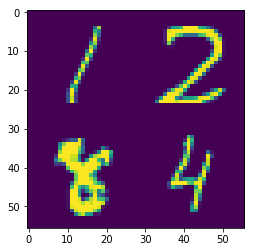

In [13]:
idx = 56
prediction = model.predict(np.expand_dims(test_imgs[idx], axis=0))

digits = (np.argsort(np.squeeze(prediction[0]))+1)[:4]
digit_sum = np.squeeze(prediction[1]).item()
print('Digits:', digits)
print('Digit Sum:', digit_sum)
plt.imshow(test_imgs[idx])
plt.show()

### Final Notes:

1. The network performs well on the classification task i.e. recognizing the digits. 
2. However, it performs poorly on regression task i.e. finding sum of digits. This is evident from the large variation in regression loss. 
    1. These results should improve with more training.
    2. One can also try adding constraints in the optimization such that the digit sum can range from [0, 36] only, thereby making this a constrained optimization problem.